# **CONDITIONAL GENERATIVE ADVERSARIAL NETWORK (CGAN)**

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

170498071/170498071 [==============================] - 4s 0us/step


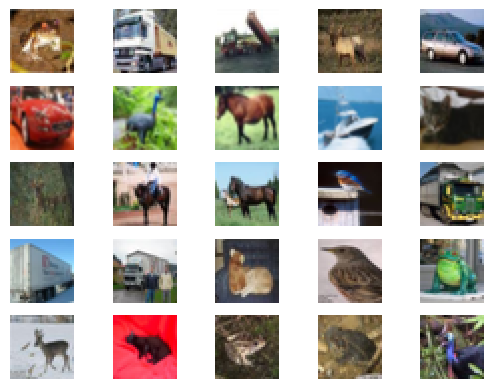

In [ ]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# **Define Discriminator Model**

In [ ]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):

	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)

	in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	out_layer = Dense(1, activation='sigmoid')(fe)
	model = Model([in_image, in_label], out_layer)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [ ]:
from tensorflow.keras import backend as K
print(K.floatx())


float32


# **DISCRIMINATOR SUMMARY**

In [ ]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                              

# **DEFINING GENERATOR MODEL**

In [ ]:
def define_generator(latent_dim, n_classes=10):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 8 * 8
	li = Dense(n_nodes)(li)
	li = Reshape((8, 8, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen)
	model = Model([in_lat, in_label], out_layer)
	return model

# **GENERATOR SUMMARY**

In [ ]:
test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                            

# **Define the combined generator and discriminator model**

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


# **LOADING AND GENERATING THE REAL IMAGES**

In [ ]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return [X, trainy]
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

# **GENERATING LATENT POINTS AND FAKE IMAGES**

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# **TRAINING AND LOADING THE GAN MODEL FOR CGAN**

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	g_model.save('cifar_conditional_generator_25epochs')



In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch231/390, d1=0.708, d2=0.698 g=0.729
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch232/390, d1=0.706, d2=0.689 g=0.713
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch233/390, d1=0.694, d2=0.696 g=0.721
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch234/390, d1=0.694, d2=0.689 g=0.716
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch235/390, d1=0.686, d2=0.691 g=0.708
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch236/390, d1=0.703, d2=0.689 g=0.704
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch237/390, d1=0.699, d2=0.704 g=0.718
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch238/390, d1=0.703, d2=0.681 g=0.699
2/2 [==============================] - 0s 3ms/step
Epoch>94, Batch239/390, d1=0.704, d2=0.704 g=0.708
2/2 [==========================

Epoch>100, Batch390/390, d1=0.712, d2=0.684 g=0.721


# **AFTER RUNNING THE EPOCHS WE GOT THE RESULTS AS**

---
***d1=0.715, d2=0.680 g=0.722***


---



# **PLOTING THE FINISHED IMAGE RESULTS AFTER THE RUNNING THE EPOCHS**

4/4 [==============================] - 0s 41ms/step


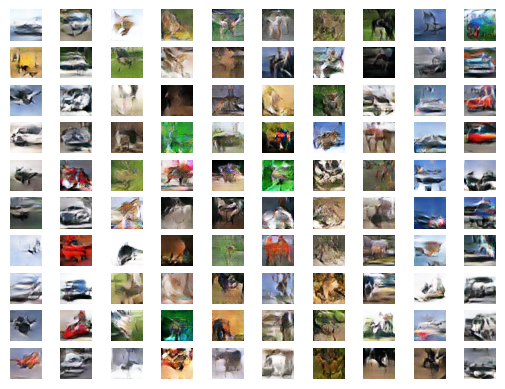

In [ ]:
from numpy import asarray
from keras.models import load_model
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
model = load_model('cifar_conditional_generator_25epochs')
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


latent_points, labels = generate_latent_points(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)

# **Frechet Inception Distance (FID)**

In [ ]:
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets import cifar10
import numpy as np
from skimage.transform import resize



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from scipy.linalg import sqrtm
import gc
mobilenet_model = MobileNet(include_top=False, pooling='avg', input_shape=(128, 128, 3))
def preprocess_and_predict(model, images, new_shape, batch_size):
    activations = []
    for i in range(0, len(images), batch_size):
        end = i + batch_size
        resized_images = np.array([resize(image, new_shape, 0, preserve_range=True, anti_aliasing=True) for image in images[i:end]], dtype=np.float32)
        preprocessed_images = preprocess_input(resized_images)
        activations.append(model.predict(preprocessed_images))
        del resized_images, preprocessed_images
        gc.collect()
    return np.concatenate(activations, axis=0)
def calculate_fid(model, images1, images2, batch_size=10):
    act1 = preprocess_and_predict(model, images1, (128, 128, 3), batch_size)
    act2 = preprocess_and_predict(model, images2, (128, 128, 3), batch_size)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid
(images_real, _), (_, _) = cifar10.load_data()
images_real = np.array([np.array(tf.image.resize(images_real[i], (128, 128))) for i in range(len(images_real))])  # Resize real images
images_generated = np.random.rand(10000, 128, 128, 3)
fid = calculate_fid(mobilenet_model, images_real, images_generated, batch_size=10)
print('FID:', fid)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
FID: 1260.2684907598161


## **INCEPTION SCORE (IS)**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image as keras_image
from scipy.stats import entropy
from PIL import Image
model = InceptionV3(include_top=True, weights='imagenet')
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray((img * 255).astype('uint8')).resize((299, 299))
        img = keras_image.img_to_array(img)
        processed_images.append(img)
    processed_images = np.array(processed_images)
    return tf.keras.applications.inception_v3.preprocess_input(processed_images)
def generate_fake_samples():
    return np.random.rand(10000, 125, 125, 3)
def inception_score(images, splits=10):
    predictions = model.predict(images, batch_size=1)
    p_yx = predictions
    p_y = np.expand_dims(p_yx.mean(axis=0), 0)
    KL_d = p_yx * (np.log(p_yx + 1e-16) - np.log(p_y + 1e-16))
    KL_d = KL_d.sum(axis=1)
    scores = np.exp(KL_d.mean())
    return scores
fake_images = generate_fake_samples()
processed_images = preprocess_images(fake_images)
is_score = inception_score(processed_images)
print("Inception Score:", is_score)


10000/10000 [==============================] - 79s 8ms/step
Inception Score: 1.0677168


# ***RESULTS***

---

**DISCRIMINATOR AND GENERATOR ACCURACY VALUES WERE - d1=0.715, d2=0.680 g=0.722**

---
**FID AND IS SCORE WERE FID: 1260.2684907598161 AND Inception Score: 1.0677168**
